In [1]:
# [1] "resnet34", Model_III, : done
# [2] "resnet34", Model_I    : done
# [3] "resnet50", Model_I    :

In [2]:
from __future__ import print_function
import os
import time
import copy
import json
import yaml

import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torchvision
from typing import *

import os
import time
import copy
import json
import yaml

import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torchvision
from typing import *

from utils.util import *
from config.data_config import DATASET
from utils.dataset import DefaultDatasetSetupSSL
from self_supervised.losses.contrastive_loss import (
    ContrastiveLossEuclidean,
    ContrastiveLossEmbedding,
    SimCLR_Loss,
    NegativeCosineSimilarity,
)
from self_supervised.losses.sym_neg_cos_sim_loss import SymNegCosineSimilarityLoss

from models.modules.head import BYOLProjectionHead, BYOLPredictionHead
from utils.scheduler import cosine_schedule
from torch.utils.data import DataLoader, random_split
from einops.layers.torch import Rearrange
from config.cvt_config import CvT_CONFIG
from models.transformer_zoo import TransformerModels
import math
from transformers import get_cosine_schedule_with_warmup
from utils.inference import InferenceSSL
from utils.trainer.simsiam_train import simsiam_train
from utils.trainer.finetune import finetune, finetune_regression

import logging
import torch
import torchvision
from torch import nn

from lightly.loss import NegativeCosineSimilarity
from lightly.models.modules import SimSiamPredictionHead, SimSiamProjectionHead
from lightly.transforms import SimSiamTransform

import matplotlib.pyplot as plt

Shape of File: (2,)
Shape of Axion: (64, 64)
Mass: <class 'numpy.float32'>


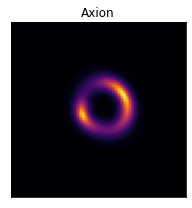

In [3]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))

folder_path = '/home/kartik/git/DeepLense/Transformers_Classification_DeepLense_Kartik_Sachdev/data/Model_II/axion'
title = 'Axion'

file_name = os.listdir(folder_path)[7]
file_path = os.path.join(folder_path, file_name)
loaded_file = np.load(file_path, allow_pickle=True)
print(f'Shape of File: {loaded_file.shape}') 

img_array = loaded_file[0]
mass = np.float32(loaded_file[1])
print(f'Shape of Axion: {loaded_file[0].shape}') 
print('Mass:', type(mass))
axs.imshow(img_array, cmap='inferno')
axs.set_title(title)
axs.set_xticks([])
axs.set_yticks([])

plt.tight_layout()
plt.show()

In [4]:
epochs_pretrain = 15
epochs_finetune = 20
ci = True
batch_size = 2
dataset_name = "Model_II" 
dataset_dir = "data"
use_cuda = True
num_workers = 8


log_dir_base = "logger" 
classes = ["axion"]
num_classes = len(classes) # can resue as network o/p, since single class with regression

In [5]:
train_config = CvT_CONFIG
learning_rate = train_config["optimizer_config"]["lr"]
num_channels = train_config["channels"]
network_type = "ResNet50" # train_config["network_type"]
image_size = train_config["image_size"]
optimizer_config = train_config["optimizer_config"]

make_directories([dataset_dir])
seed_everything(seed=42)

In [6]:
# logging
current_time = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
log_dir_name = f"{current_time}_SimSiam_{network_type}_{dataset_name}"
log_dir = f"{log_dir_base}/{log_dir_name}"
init_logging_handler(log_dir_base, log_dir_name)

# dump config in logger
with open(f"{log_dir}/config.json", "w") as fp:
    json.dump(train_config, fp)

In [7]:
# paths
model_path_pretrained = os.path.join(
    f"{log_dir}/checkpoint",
   f"{network_type}_pretrained_{dataset_name}_{current_time}.pt",
)

finetuned_model_path = os.path.join(
    f"{log_dir}/checkpoint",
    f"{network_type}_finetune_{dataset_name}_{current_time}.pt",
)

In [8]:
train_config = CvT_CONFIG
learning_rate = train_config["optimizer_config"]["lr"]
num_channels = train_config["channels"]
network_type = train_config["network_type"]
image_size = train_config["image_size"]
optimizer_config = train_config["optimizer_config"]

make_directories([dataset_dir])
seed_everything(seed=42)

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2


class SimSiamTransform:
    """Implements the global and local view augmentations for DINO [0].
    """

    def __init__(self):
        pass
    
    def get_transforms(self, 
                       global_crop_size: int = 224,
                       global_crop_scale: Tuple[float, float] = (0.4, 1.0),
                       local_crop_size: int = 96,
                       local_crop_scale: Tuple[float, float] = (0.05, 0.4),):

        # first global crop
        global_transform_0 = A.Compose(
        [
            A.HorizontalFlip(p=0.25),
            A.VerticalFlip(p=0.25),
            A.Resize(global_crop_size, global_crop_size, p=1.0),
            A.RandomResizedCrop(height=global_crop_size, width=global_crop_size),
            A.Rotate(p=0.5), 
            ToTensorV2(),
        ])

        # second global crop
        global_transform_1 = A.Compose(
        [
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.25),
            A.Resize(global_crop_size, global_crop_size, p=1.0),
            A.augmentations.GaussNoise(var_limit=(0.002, 0.005), p=0.3),
            ToTensorV2(),
        ])
        
        # transformation for the local small crops
        local_transform = A.Compose(
        [
            A.HorizontalFlip(p=0.25),
            A.VerticalFlip(p=0.25),
            A.Resize(local_crop_size, local_crop_size, p=1.0),
            A.augmentations.GaussianBlur(),
            ToTensorV2(),
        ])
        return [global_transform_0, global_transform_0]
    

In [10]:
from utils.dataset import visualize_samples_ssl, DeepLenseDatasetSSL, DeepLenseDatasetSSLRegression
# trainset
dino_transform = SimSiamTransform()
train_transforms = dino_transform.get_transforms()
train_dataset = DeepLenseDatasetSSLRegression(destination_dir = dataset_dir, transforms = train_transforms, mode="train", dataset_name=dataset_name, download=True, channels=1, classes=classes)


Model_II dataset already exists


In [11]:
batch = train_dataset[2]
batch

[tensor([[[2.8187e-06, 2.9459e-06, 3.0636e-06,  ..., 7.8366e-10,
           8.7842e-10, 9.8399e-10],
          [2.4232e-06, 2.5288e-06, 2.6264e-06,  ..., 9.0712e-10,
           1.0194e-09, 1.1434e-09],
          [2.0678e-06, 2.1538e-06, 2.2328e-06,  ..., 1.0329e-09,
           1.1601e-09, 1.2990e-09],
          ...,
          [7.6996e-09, 6.9931e-09, 6.3493e-09,  ..., 2.0863e-09,
           1.9723e-09, 1.8700e-09],
          [6.4383e-09, 5.8432e-09, 5.2998e-09,  ..., 2.4426e-09,
           2.3074e-09, 2.1879e-09],
          [5.3242e-09, 4.8503e-09, 4.4148e-09,  ..., 2.8189e-09,
           2.6457e-09, 2.5046e-09]]]),
 tensor([[[5.0181e-07, 5.0181e-07, 5.0181e-07,  ..., 2.3711e-01,
           2.6423e-01, 2.8002e-01],
          [5.0035e-07, 5.0035e-07, 5.0035e-07,  ..., 2.3284e-01,
           2.5985e-01, 2.7558e-01],
          [4.9761e-07, 4.9761e-07, 4.9761e-07,  ..., 2.2484e-01,
           2.5166e-01, 2.6727e-01],
          ...,
          [2.5459e-11, 2.5459e-11, 2.5459e-11,  ..., 2.544

DEBUG:root:train data: 29896


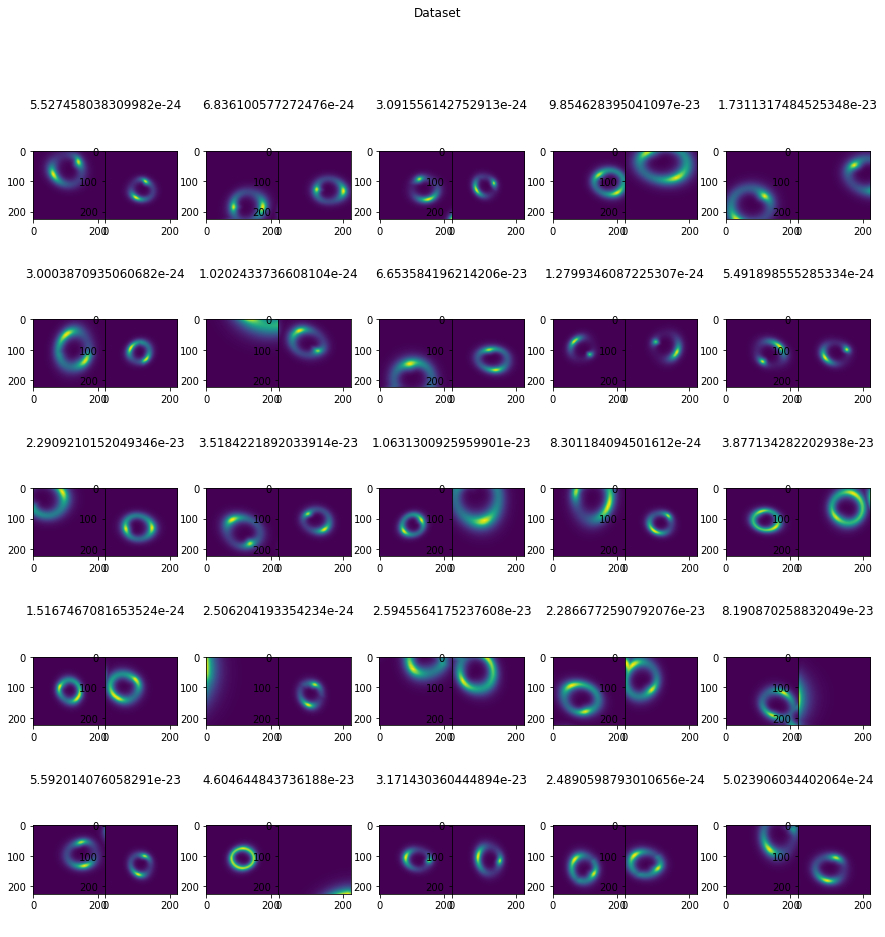

In [12]:
logging.debug(f"train data: {len(train_dataset)}")
visualize_samples_ssl(train_dataset, labels_map=classes, num_rows_inner=1, num_cols_inner=2, regression=True)

In [13]:
# split in train and valid set
split_ratio = 0.25  # 0.25
valid_len = int(split_ratio * len(train_dataset))
train_len = len(train_dataset) - valid_len

train_dataset, val_set = random_split(train_dataset, [train_len, valid_len])

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
)

val_loader = DataLoader(
    dataset=val_set, batch_size=batch_size, shuffle=True, num_workers=num_workers
)

# Load test dataset
# testset = default_dataset_setup.get_dataset(mode="val")
# test_loader = DataLoader(dataset=testset, batch_size=batch_size, shuffle=True)

# size check
sample = next(iter(train_loader))
logging.debug("num of classes: ", num_classes)
logging.debug(sample[0].shape)

--- Logging error ---
Traceback (most recent call last):
  File "/home/kartik/anaconda3/envs/dlvr/lib/python3.8/logging/__init__.py", line 1081, in emit
    msg = self.format(record)
  File "/home/kartik/anaconda3/envs/dlvr/lib/python3.8/logging/__init__.py", line 925, in format
    return fmt.format(record)
  File "/home/kartik/anaconda3/envs/dlvr/lib/python3.8/logging/__init__.py", line 664, in format
    record.message = record.getMessage()
  File "/home/kartik/anaconda3/envs/dlvr/lib/python3.8/logging/__init__.py", line 369, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/home/kartik/anaconda3/envs/dlvr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/kartik/anaconda3/envs/dlvr/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/home/kartik/anaconda3/envs/dlvr/lib/python3.8/site-packages/ipykernel_launcher

In [14]:
class SimSiam(nn.Module):
    def __init__(self, backbone):
        super().__init__()
        self.backbone = backbone
        self.backbone[0] = nn.Conv2d(
            1, 64, kernel_size=7, stride=2, padding=3, bias=False
        )
        self.projection_head = SimSiamProjectionHead(2048, 512, 128)
        self.prediction_head = SimSiamPredictionHead(128, 64, 128)

    def forward(self, x):
        f = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(f)
        p = self.prediction_head(z)
        z = z.detach()
        return z, p



In [15]:
# # Create ResNet pretrain model
resnet = torchvision.models.resnet50() # -> [1] Model_III, "resnet34", (2)  Model_I, "resnet34", (3)  Model_I, "resnet50",
backbone = nn.Sequential(*list(resnet.children())[:-1])

num_ftrs_dict = {
    "resnet18": 512,
    "resnet34": 512,
    "resnet50": 2048,

}

model =  SimSiam(backbone)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

summary(model, input_size=(2, 1, 224, 224), device="cuda")

/home/kartik/anaconda3/envs/dlvr/lib/python3.8/site-packages/torchinfo/torchinfo.py:415: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


Layer (type:depth-idx)                        Output Shape              Param #
SimSiam                                       --                        --
├─Sequential: 1-1                             [2, 2048, 1, 1]           --
│    └─Conv2d: 2-1                            [2, 64, 112, 112]         3,136
│    └─BatchNorm2d: 2-2                       [2, 64, 112, 112]         128
│    └─ReLU: 2-3                              [2, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [2, 64, 56, 56]           --
│    └─Sequential: 2-5                        [2, 256, 56, 56]          --
│    │    └─Bottleneck: 3-1                   [2, 256, 56, 56]          75,008
│    │    └─Bottleneck: 3-2                   [2, 256, 56, 56]          70,400
│    │    └─Bottleneck: 3-3                   [2, 256, 56, 56]          70,400
│    └─Sequential: 2-6                        [2, 512, 28, 28]          --
│    │    └─Bottleneck: 3-4                   [2, 512, 28, 28]          379,392

In [16]:
#optimizer
optimizer_pretrain = optim.AdamW(model.parameters(), lr=1e-3, weight_decay = 1e-4)
warmup_epochs = 3
num_train_steps = math.ceil(len(train_loader))
num_warmup_steps= num_train_steps * warmup_epochs
num_training_steps=int(num_train_steps * epochs_pretrain)

#learning rate scheduler
cosine_scheduler = get_cosine_schedule_with_warmup(optimizer_pretrain,num_warmup_steps = num_warmup_steps,num_training_steps =num_training_steps) 

In [17]:
criterion = NegativeCosineSimilarity()

In [18]:
simsiam_train(
    epochs=epochs_pretrain,
    model=model,
    device=device,
    train_loader=train_loader,
    criterion=criterion,
    optimizer=optimizer_pretrain,
    use_lr_schedule=True,
    scheduler=cosine_scheduler,
    path=model_path_pretrained,
    log_freq=100,
    ci=ci,
)


DEBUG:root:Starting Training
DEBUG:root:epoch: 00, loss: -0.00000
DEBUG:root:epoch: 01, loss: -0.00000
DEBUG:root:epoch: 02, loss: 0.00001
DEBUG:root:epoch: 03, loss: -0.00000
DEBUG:root:epoch: 04, loss: 0.00001
DEBUG:root:epoch: 05, loss: -0.00000
DEBUG:root:epoch: 06, loss: -0.00000
DEBUG:root:epoch: 07, loss: 0.00000
DEBUG:root:epoch: 08, loss: -0.00000
DEBUG:root:epoch: 09, loss: 0.00000
DEBUG:root:epoch: 10, loss: 0.00000
DEBUG:root:epoch: 11, loss: -0.00000
DEBUG:root:epoch: 12, loss: 0.00000
DEBUG:root:epoch: 13, loss: -0.00001
DEBUG:root:epoch: 14, loss: -0.00001


In [19]:
class FinetuneClassifier(nn.Module):
    def __init__(self, backbone, head):
        super(FinetuneClassifier, self).__init__()
        self.backbone = backbone
        self.head = head

    def forward(self, x):
        z = self.backbone[0](x).flatten(start_dim=1)
        z = self.backbone[1](z)
        z = self.head(z)
        return z

In [20]:
# load model
backbone = nn.Sequential(model.backbone, model.projection_head)
classification_head = nn.Sequential(
    nn.Linear(128, 512), # num_ftrs_dict["resnet34"]
    nn.ReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512, num_classes),)

model =  FinetuneClassifier(backbone, classification_head) # num_ftrs_dict["resnet34"]
# model.load_state_dict(torch.load(model_path_pretrained))
summary(model, input_size=(2, 1, 224, 224), device="cuda")

Layer (type:depth-idx)                             Output Shape              Param #
FinetuneClassifier                                 --                        --
├─Sequential: 1                                    --                        --
│    └─Sequential: 2-1                             [2, 2048, 1, 1]           --
│    │    └─Conv2d: 3-1                            [2, 64, 112, 112]         3,136
│    │    └─BatchNorm2d: 3-2                       [2, 64, 112, 112]         128
│    │    └─ReLU: 3-3                              [2, 64, 112, 112]         --
│    │    └─MaxPool2d: 3-4                         [2, 64, 56, 56]           --
│    │    └─Sequential: 3-5                        [2, 256, 56, 56]          215,808
│    │    └─Sequential: 3-6                        [2, 512, 28, 28]          1,219,584
│    │    └─Sequential: 3-7                        [2, 1024, 14, 14]         7,098,368
│    │    └─Sequential: 3-8                        [2, 2048, 7, 7]           14,964,736
│   

In [21]:
import math
learning_rate = 3e-4 # 3e-4
weight_decay =  0.01

finetune_optimizer = optim.AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
)

#optimizer
optimizer_finetune = optim.AdamW(model.parameters(), lr=learning_rate) #  weight_decay = 1e-4
warmup_epochs = 3
num_train_steps = math.ceil(len(train_loader))
num_warmup_steps= num_train_steps * warmup_epochs
num_training_steps=int(num_train_steps * epochs_finetune)

#learning rate scheduler
cosine_scheduler = get_cosine_schedule_with_warmup(optimizer_finetune,num_warmup_steps = num_warmup_steps,num_training_steps =num_training_steps) 

In [22]:
criterion_finetune = nn.MSELoss()

In [23]:
# Finetune
finetune_regression(
    epochs_finetune,
    model,
    device,
    train_loader,
    criterion_finetune,
    optimizer_finetune,
    finetuned_model_path,
    valid_loader=val_loader,
    scheduler=cosine_scheduler,
    ci=ci,
)

output:  torch.float32
label:  torch.float32


/home/kartik/anaconda3/envs/dlvr/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
DEBUG:root:====== Eval started ======
DEBUG:root:====== Model saved ======
DEBUG:root:Epoch : 1 - loss : 0.0000 - val_loss : 0.0000 

DEBUG:root:====== Eval started ======


output:  torch.float32
label:  torch.float32


DEBUG:root:====== Model saved ======
DEBUG:root:Epoch : 2 - loss : 0.0000 - val_loss : 0.0000 

DEBUG:root:====== Eval started ======


output:  torch.float32
label:  torch.float32


DEBUG:root:Epoch : 3 - loss : 0.0000 - val_loss : 0.0000 

DEBUG:root:====== Eval started ======


output:  torch.float32
label:  torch.float32


DEBUG:root:Epoch : 4 - loss : 0.0000 - val_loss : 0.0000 

DEBUG:root:====== Eval started ======


output:  torch.float32
label:  torch.float32


DEBUG:root:Epoch : 5 - loss : 0.0000 - val_loss : 0.0000 

DEBUG:root:====== Eval started ======


output:  torch.float32
label:  torch.float32


DEBUG:root:====== Model saved ======
DEBUG:root:Epoch : 6 - loss : 0.0000 - val_loss : 0.0000 

DEBUG:root:====== Eval started ======


output:  torch.float32
label:  torch.float32


DEBUG:root:Epoch : 7 - loss : 0.0000 - val_loss : 0.0000 

DEBUG:root:====== Eval started ======


output:  torch.float32
label:  torch.float32


DEBUG:root:Epoch : 8 - loss : 0.0000 - val_loss : 0.0000 

DEBUG:root:====== Eval started ======


output:  torch.float32
label:  torch.float32


DEBUG:root:====== Model saved ======
DEBUG:root:Epoch : 9 - loss : 0.0000 - val_loss : 0.0000 

DEBUG:root:====== Eval started ======


output:  torch.float32
label:  torch.float32


DEBUG:root:Epoch : 10 - loss : 0.0000 - val_loss : 0.0000 

DEBUG:root:====== Eval started ======


output:  torch.float32
label:  torch.float32


DEBUG:root:====== Model saved ======
DEBUG:root:Epoch : 11 - loss : 0.0000 - val_loss : 0.0000 

DEBUG:root:====== Eval started ======


output:  torch.float32
label:  torch.float32


DEBUG:root:Epoch : 12 - loss : 0.0000 - val_loss : 0.0000 

DEBUG:root:====== Eval started ======


output:  torch.float32
label:  torch.float32


DEBUG:root:Epoch : 13 - loss : 0.0000 - val_loss : 0.0000 

DEBUG:root:====== Eval started ======


output:  torch.float32
label:  torch.float32


DEBUG:root:====== Model saved ======
DEBUG:root:Epoch : 14 - loss : 0.0000 - val_loss : 0.0000 

DEBUG:root:====== Eval started ======


output:  torch.float32
label:  torch.float32


DEBUG:root:Epoch : 15 - loss : 0.0000 - val_loss : 0.0000 

DEBUG:root:====== Eval started ======


output:  torch.float32
label:  torch.float32


DEBUG:root:Epoch : 16 - loss : 0.0000 - val_loss : 0.0000 

DEBUG:root:====== Eval started ======


output:  torch.float32
label:  torch.float32


DEBUG:root:====== Model saved ======
DEBUG:root:Epoch : 17 - loss : 0.0001 - val_loss : 0.0000 

DEBUG:root:====== Eval started ======


output:  torch.float32
label:  torch.float32


DEBUG:root:Epoch : 18 - loss : 0.0000 - val_loss : 0.0000 

DEBUG:root:====== Eval started ======


output:  torch.float32
label:  torch.float32


DEBUG:root:Epoch : 19 - loss : 0.0000 - val_loss : 0.0000 

DEBUG:root:====== Eval started ======


output:  torch.float32
label:  torch.float32


DEBUG:root:Epoch : 20 - loss : 0.0000 - val_loss : 0.0000 

